In [1]:
from my_models import *
import numpy as np
from Config import Config
from tensorflow.keras.utils import to_categorical

In [2]:
from utils import seed_everything
seed_everything(42)

In [3]:
DATA_ROOT = Config.DATA_ROOT
DATA_PATH = 'RAVDESS'
CLASS_LABELS = Config.RAVDESS_LABELS
k = 10

feature_name = 'mfcc'
model_name = '(64 CNN, Last dilated)+CBAM+Depthwise-separable-Caps+CA+SA+CA+Capsule+CA'

learning_rate=0.001
beta_1=0.975
beta_2=0.932
epsilon=1e-8

EPOCHS = 300
BATCH = 32

In [4]:
class Model(tf.keras.Model):

  def __init__(self, num_classes):
    super().__init__()
    
    self.conv1 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2)
    ])
    
    self.conv2 = Sequential([
      Conv2D(filters=64, kernel_size=3, dilation_rate=2),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
    
    self.cbam = CBAM(64) # sharing
    
    self.primarycap = PrimaryCap()
    self.spatial_attn = SpatialGate()
    
    self.attention = Attention(use_scale=True)
    self.LN = LayerNormalization()
    
    self.lamb = Lambda(lambda x: tf.multiply(x[0], x[1]))
    
    self.capsule = Capsule(6,64,3,True)
    self.gap = GlobalAveragePooling1D()
    self.dropout = Dropout(0.2)
    self.classifier = Dense(num_classes, activation='softmax')
    
    
  def call(self, inputs):
    x = inputs
    
    cap = self.conv1(x)
    cap = cap + self.cbam(cap)
    cap = self.conv2(cap)
    cap = cap + self.cbam(cap)
    
    primarycaps = self.primarycap(cap)
    primarycaps = tf.expand_dims(primarycaps, axis=-1)
    primarycaps = primarycaps + self.spatial_attn(primarycaps)
    primarycaps = tf.squeeze(primarycaps, axis=-1)
    
    cap = primarycaps
    
    sa = self.attention([primarycaps, primarycaps, primarycaps])
    sa = self.LN(sa)
    
    sa = tf.expand_dims(sa, axis=-1)
    sa = sa + self.spatial_attn(sa)
    sa = tf.squeeze(sa, axis=-1)
    
    cap = self.lamb([cap, sa])
    cap = tf.expand_dims(cap, axis=-1)
    cap = cap + self.spatial_attn(cap)
    cap = tf.squeeze(cap, axis=-1)
    
    capsule = self.capsule(cap)
    capsule = tf.expand_dims(capsule, axis=-1)
    capsule = capsule + self.spatial_attn(capsule)
    capsule = tf.squeeze(capsule, axis=-1)
    
    gap = self.gap(capsule)
    drop = self.dropout(gap)
    
    output_softmax = self.classifier(drop)
    return output_softmax

In [5]:
class Model2(tf.keras.Model):

  def __init__(self, num_classes):
    super().__init__()
    
    self.conv1 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2)
    ])
    
    self.conv2 = Sequential([
      Conv2D(filters=64, kernel_size=3, dilation_rate=2),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
    
    self.cbam = CBAM(64) # sharing
    
    self.primarycap = PrimaryCap()
    self.spatial_attn = SpatialGate()
    
    self.attention = Attention(use_scale=True)
    self.LN = LayerNormalization()
    
    self.lamb = Lambda(lambda x: tf.multiply(x[0], x[1]))
    
    self.capsule = Capsule(6,64,3,True)
    self.gap = GlobalAveragePooling1D()
    
    
  def call(self, inputs):
    x = inputs
    
    cap = self.conv1(x)
    cap = cap + self.cbam(cap)
    cap = self.conv2(cap)
    cap = cap + self.cbam(cap)
    
    primarycaps = self.primarycap(cap)
    primarycaps = tf.expand_dims(primarycaps, axis=-1)
    primarycaps = primarycaps + self.spatial_attn(primarycaps)
    primarycaps = tf.squeeze(primarycaps, axis=-1)
    
    cap = primarycaps
    
    sa = self.attention([primarycaps, primarycaps, primarycaps])
    sa = self.LN(sa)
    
    sa = tf.expand_dims(sa, axis=-1)
    sa = sa + self.spatial_attn(sa)
    sa = tf.squeeze(sa, axis=-1)
    
    cap = self.lamb([cap, sa])
    cap = tf.expand_dims(cap, axis=-1)
    cap = cap + self.spatial_attn(cap)
    cap = tf.squeeze(cap, axis=-1)
    
    capsule = self.capsule(cap)
    capsule = tf.expand_dims(capsule, axis=-1)
    capsule = capsule + self.spatial_attn(capsule)
    capsule = tf.squeeze(capsule, axis=-1)
    
    gap = self.gap(capsule)
    return gap

In [6]:
# Read data
with open(f'{DATA_ROOT}/{DATA_PATH}.npy', 'rb') as f:
    x = np.load(f)
    y = np.load(f)

y = to_categorical(y,num_classes=len(CLASS_LABELS))

In [7]:
model_root_path = 'Models/RAVDESS'
model_root_path = f'{model_root_path}/{model_name}_'

In [8]:
accuracies = []

In [9]:
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn.metrics import accuracy_score

kfold = KFold(n_splits=k, shuffle=True, random_state=98)

for i, (train, test) in enumerate(kfold.split(x, y)):
    x_test, y_test = x[test], y[test]
    x_test = tf.expand_dims(x_test, axis=-1)
    
    cur_h5_path = f'{model_root_path}{i}-fold_.h5'
    
    model = Model(len(CLASS_LABELS))
    model.build(input_shape=x_test.shape)
    model.load_weights(cur_h5_path)
    
    acc = []
    
    batch_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH)
    for features, labels in batch_test:
        pred = model(features, training=False)
        y_pred = np.argmax(pred, axis=-1)
        y_true = np.argmax(labels, axis=-1)
        acc.append(accuracy_score(y_true, y_pred) * 100)
        
    accuracies.append(sum(acc)/len(acc))
        

In [10]:
accuracies = np.array(accuracies)
best_fold = np.argmax(accuracies)
best_acc = accuracies[best_fold]

In [11]:
x_test = None
y_test = None

kfold = KFold(n_splits=k, shuffle=True, random_state=98)

for i, (train, test) in enumerate(kfold.split(x, y)):
    if i != best_fold:
        continue
    
    x_test, y_test = x[test], y[test]
    x_test = tf.expand_dims(x_test, axis=-1)
    break

In [12]:
best_h5_path = f'{model_root_path}{best_fold}-fold_.h5'

origin = Model(len(CLASS_LABELS))
origin.build(input_shape=x_test.shape)
origin.load_weights(best_h5_path)

In [13]:
def get_layers_weights(origin_model):
    """_summary_

    Args:
        origin_model (_type_): _description_

    Returns:
        _type_: _description_
    """
    ret = []
    
    copy_layers = origin_model.layers[:-2]
    for cur_layer in copy_layers:
        ret.append(cur_layer.get_weights())
    
    return ret

In [14]:
origin_layers_weights = get_layers_weights(origin)
len(origin_layers_weights)

10

In [15]:
test_model = Model2(len(CLASS_LABELS))
test_model.build(input_shape=x_test.shape)

In [16]:
test_model_layers = test_model.layers
for i, cur_test_layer in enumerate(test_model_layers):
    cur_test_layer.set_weights(origin_layers_weights[i])

In [17]:
from sklearn.manifold import TSNE
import numpy as np
from  matplotlib import pyplot as plt

In [18]:
features = test_model(x_test, training=False)
labels = np.argmax(y_test, axis=1)

In [19]:
features = tf.reshape(features, [features.shape[0], -1])
features.shape

TensorShape([144, 64])

In [20]:
color_tables = ["tab:blue", "tab:orange", "black", "tab:red", "tab:purple", "tab:gray", "tab:olive", "tab:brown"]

In [21]:
color_tables = [color_tables[i] for i in range(len(CLASS_LABELS))]

tsne = TSNE(n_components=2, perplexity=50).fit_transform(features)
tsne[0]

array([-3.4553823, -1.6543887], dtype=float32)

In [22]:
tx = tsne[:, 0]
ty = tsne[:, 1]

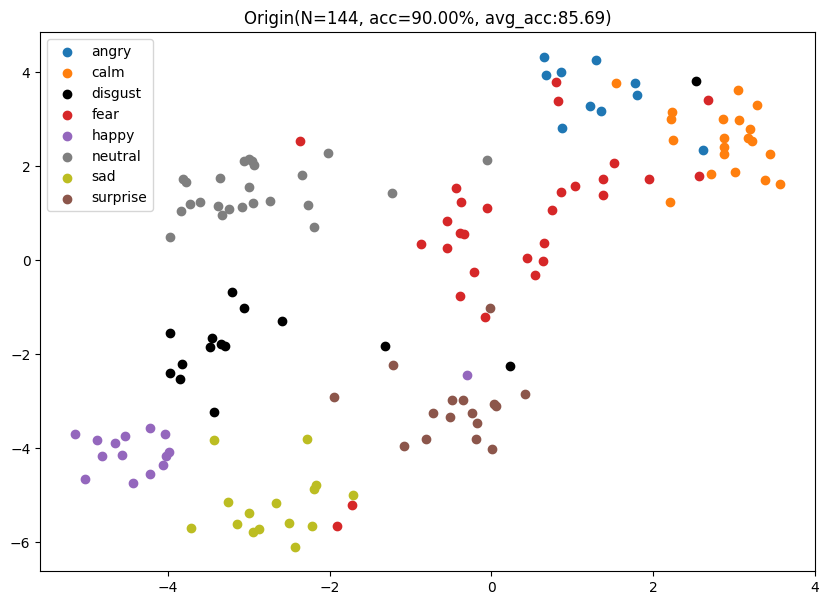

In [23]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()

classes = CLASS_LABELS
fig_save_path = f'Fig/{DATA_PATH}/visualization'
os.makedirs(fig_save_path, exist_ok=True)

for idx, c in enumerate(color_tables):
    indices = [i for i, l in enumerate(labels) if idx == l]
    cur_tx = np.take(tx, indices)
    cur_ty = np.take(ty, indices)
    ax.scatter(cur_tx, cur_ty, c=c, label=classes[idx])
    
ax.legend(loc='best')
plt.title(f'Origin(N={len(labels)}, acc={best_acc:.2f}%, avg_acc:{sum(accuracies)/len(accuracies):.2f})')

plt.savefig(os.path.join(fig_save_path, f'origin_{best_fold + 1}-Fold.PNG'))

plt.show()